<a href="https://colab.research.google.com/github/YooJung-Moon/K-melon/blob/main/ResNet50_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import load_img, img_to_array, array_to_img
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd "/content"
# # %cd "/content/drive/MyDrive"
# !mkdir img

/content


### Data Download

In [ ]:
!wget https://www.dropbox.com/s/diwzbpumn81dwhd/img4.zip?dl=0

--2023-06-19 03:51:11--  https://www.dropbox.com/s/diwzbpumn81dwhd/img4.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/diwzbpumn81dwhd/img4.zip [following]
--2023-06-19 03:51:11--  https://www.dropbox.com/s/raw/diwzbpumn81dwhd/img4.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc40b427d026bfa0cf1c92f0813d.dl.dropboxusercontent.com/cd/0/inline/B-SM9eqhcxakSwFev2wKFpTHcfw0ZCqAnkKL4DpZnt9W-kQuq0U-Nd0EdqvQ-ok7t1Omy2092S3SHVHFvmxUBDIUrTxLZFazWtmsGf5KQQGxNLwEXi_6idaSpqCavDCSiR86n-qU2Wu1bO9RfLhN-voGe0t-2cRCo6lrn4RS8ooWxA/file# [following]
--2023-06-19 03:51:12--  https://uc40b427d026bfa0cf1c92f0813d.dl.dropboxusercontent.com/cd/0/inline/B-SM9eqhcxakSwFev2wKFpTHcfw0ZCqAnkKL4DpZnt9W-kQuq0U-Nd0EdqvQ-ok7t1Omy2092S3SHVHFvmxUBDI

In [ ]:
# !unzip '/content/drive/MyDrive/deeplearning/img4.zip' -d '/content/img'
!unzip '/content/img4.zip?dl=0'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: img4/val/정상/S027-FM02-027-2022-06-28-000074.jpg  
  inflating: __MACOSX/img4/val/정상/._S027-FM02-027-2022-06-28-000074.jpg  
  inflating: img4/val/정상/S026-FM02-026-2022-06-28-000043.jpg  
  inflating: __MACOSX/img4/val/정상/._S026-FM02-026-2022-06-28-000043.jpg  
  inflating: img4/val/정상/S051-FM03-051-2022-07-05-000049.jpg  
  inflating: __MACOSX/img4/val/정상/._S051-FM03-051-2022-07-05-000049.jpg  
  inflating: img4/val/정상/S009-FM01-009-2022-06-27-000092.jpg  
  inflating: __MACOSX/img4/val/정상/._S009-FM01-009-2022-06-27-000092.jpg  
  inflating: img4/val/정상/S024-FM02-024-2022-06-28-000005.jpg  
  inflating: __MACOSX/img4/val/정상/._S024-FM02-024-2022-06-28-000005.jpg  
  inflating: img4/val/정상/S034-FM02-034-2022-07-09-000016.jpg  
  inflating: __MACOSX/img4/val/정상/._S034-FM02-034-2022-07-09-000016.jpg  
  inflating: img4/val/정상/S010-FM01-010-2022-06-30-000043.jpg  
  inflating: __MACOSX/img4/

### Data preprocessing

In [ ]:
epochs = 50
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

Data Augmentation

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                          shear_range = 60,                                                                                                                    # shear_range = 60,
                                                          brightness_range = (0.8,1.2),
                                                          horizontal_flip = True)
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_gen.flow_from_directory(directory="/content/img4/train",
                                        target_size = (IMG_WIDTH,IMG_HEIGHT),
                                        class_mode='categorical',
                                        batch_size = batch_size)
val_set = img_gen.flow_from_directory(directory="/content/img4/val",
                                        target_size = (IMG_WIDTH,IMG_HEIGHT),
                                        class_mode='categorical',
                                        batch_size = batch_size)
test_set = img_gen.flow_from_directory(directory="/content/img4/test",
                                        target_size = (IMG_WIDTH,IMG_HEIGHT),
                                        class_mode='categorical',
                                        batch_size = batch_size)

Found 32855 images belonging to 5 classes.
Found 8268 images belonging to 5 classes.
Found 1670 images belonging to 5 classes.


### Build Transfer Model

Load ResNet50, except fc layer(include_top = False)

In [ ]:
model_res50 = applications.ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model_res50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

new network

In [ ]:
x = model_res50.output
x = GlobalAveragePooling2D()(x)

x = Flatten()(x)

predictions = Dense(5, activation='softmax')(x)

model_transfer = Model(inputs=model_res50.input, outputs=predictions)

In [ ]:
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

### Train Model

In [ ]:
model_transfer.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(
    learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
history = model_transfer.fit(train_set, epochs=epochs, batch_size = batch_size,validation_data=val_set)

Epoch 1/50
1027/1027 [==============================] - 665s 599ms/step - loss: 0.2724 - accuracy: 0.9046 - val_loss: 0.6515 - val_accuracy: 0.7783
Epoch 2/50
1027/1027 [==============================] - 592s 576ms/step - loss: 0.1550 - accuracy: 0.9461 - val_loss: 0.1204 - val_accuracy: 0.9596
Epoch 3/50
1027/1027 [==============================] - 589s 573ms/step - loss: 0.1378 - accuracy: 0.9516 - val_loss: 0.1651 - val_accuracy: 0.9479
Epoch 4/50
1027/1027 [==============================] - 599s 582ms/step - loss: 0.1229 - accuracy: 0.9580 - val_loss: 0.1592 - val_accuracy: 0.9456
Epoch 5/50
1027/1027 [==============================] - 602s 586ms/step - loss: 0.1118 - accuracy: 0.9613 - val_loss: 0.1389 - val_accuracy: 0.9544
Epoch 6/50
1027/1027 [==============================] - 595s 579ms/step - loss: 0.1024 - accuracy: 0.9640 - val_loss: 0.1597 - val_accuracy: 0.9492
Epoch 7/50
1027/1027 [==============================] - 589s 574ms/step - loss: 0.0944 - accuracy: 0.9667 - val_

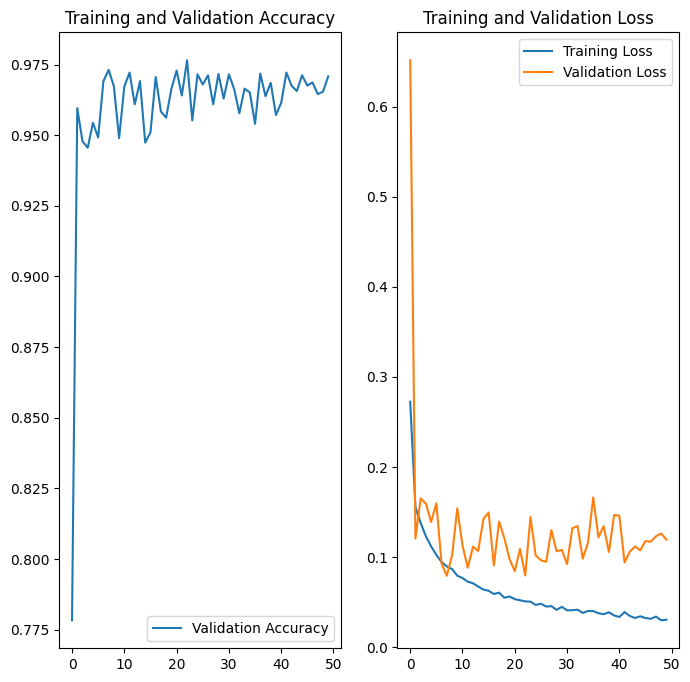

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')

plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# %cd "/content/drive/MyDrive/deeplearning"
# model_transfer.save("50epoch_aug_5class_Transfer_ResNet50.h5")

/content/drive/MyDrive/deeplearning


In [ ]:
# from keras.models import load_model
# model_transfer = load_model('/content/drive/MyDrive/deeplearning/Transfer_ResNet50.h5')

### Evaluate Model and Confusion Matrix

In [ ]:
model_transfer.evaluate(test_set)

209/209 [==============================] - 9s 41ms/step - loss: 1.7933 - accuracy: 0.6820


[1.7933005094528198, 0.6820359230041504]

In [ ]:
images = []
labels = []

def load_image():
  global images, labels
  dir = "/content/img4/test/"
  class_dir = ['노균병','노균병유사','정상','흰가루병','흰가루병유사']
  for index in range(len(class_dir)):
    list_dir = dir+class_dir[index]+"/"
    for j in os.listdir(list_dir):
      if j == ".ipynb_checkpoints":
        continue
      img = load_img(list_dir+j)
      test_array = img_to_array(img)
      test_x = tf.expand_dims(img,0)
      images.append(test_x)
      labels.append(index)
load_image()
labels = np.array(labels)

In [ ]:
y = []
for i in range(len(images)):
  predictions = model.predict(images[i]/255)
  pred = np.argmax(predictions)
  y.append(pred)
class_names = list(test_set.class_indices.keys())
confusion_matrix = confusion_matrix(y, labels)
print(confusion_matrix)
print('Classification Report:')
print(classification_report(y, labels, target_names=class_names))

1/1 [==============================] - 1s 1s/step
[[9.9999893e-01 3.9617388e-34 3.0668546e-18 1.1040187e-06 8.9071130e-23]]
1/1 [==============================] - 0s 24ms/step
[[9.9977046e-01 0.0000000e+00 3.3014017e-29 2.2959952e-04 2.7300496e-33]]
1/1 [==============================] - 0s 23ms/step
[[7.1050692e-03 3.7426953e-16 2.0675354e-05 9.9287426e-01 9.1402871e-11]]
1/1 [==============================] - 0s 34ms/step
[[8.1128016e-02 6.1376040e-17 6.4606354e-08 9.1887182e-01 1.6823485e-11]]
1/1 [==============================] - 0s 31ms/step
[[2.6251671e-01 9.8195223e-06 3.3634494e-06 7.3747009e-01 5.4370599e-08]]
1/1 [==============================] - 0s 28ms/step
[[9.9924242e-01 0.0000000e+00 9.2643566e-23 7.5756537e-04 2.3045493e-24]]
1/1 [==============================] - 0s 26ms/step
[[4.1614634e-01 2.1165196e-34 1.6543350e-15 5.8385372e-01 3.9704752e-18]]
1/1 [==============================] - 0s 22ms/step
[[4.4072452e-01 2.5223770e-27 2.6202870e-12 5.5927545e-01 7.5093962e

In [ ]:
confusion_matrix = metrics.confusion_matrix(y, labels) #test_set
print(confusion_matrix)

[[305   0   0 105   2]
 [  0 257  66  19  40]
 [  0 133 315  16  14]
 [ 94   6  18 253   9]
 [  0   3   0   6   9]]
